In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784")

In [44]:
data, target = mnist["data"], mnist["target"]
print(f"data의 type : {type(data)},   data의 shape : {data.shape}")
print(f"target의 type : {type(target)},   target의 shape : {target.shape}")

data의 type : <class 'pandas.core.frame.DataFrame'>,   data의 shape : (70000, 784)
target의 type : <class 'pandas.core.series.Series'>,   target의 shape : (70000,)


In [45]:
target.dtypes

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False)

In [46]:
target = target.astype(np.int8)
data, target = data.values, target.values

print(f"data의 type : {type(data)},   data의 shape : {data.shape}")
print(f"target의 type : {type(target)},   target의 shape : {target.shape}")

data의 type : <class 'numpy.ndarray'>,   data의 shape : (70000, 784)
target의 type : <class 'numpy.ndarray'>,   target의 shape : (70000,)


In [47]:
print(target[10:20])

[3 5 3 6 1 7 2 8 6 9]


In [48]:
target_dict = {}
label, freq = np.unique(target, return_counts=True)

for l, f in zip(label, freq):
    target_dict[l] = f
    
print(target_dict)

{0: 6903, 1: 7877, 2: 6990, 3: 7141, 4: 6824, 5: 6313, 6: 6876, 7: 7293, 8: 6825, 9: 6958}


In [49]:
data = data / 255       # To keep our gradients manageable
print(np.max(data), np.min(data))

1.0 0.0


In [50]:
target.shape

(70000,)

In [51]:
digits = 10
examples = target.shape[0]

target_new = np.eye(digits)[target.reshape(1,-1)]

print(target_new.shape)
print(target_new[:, 10:20])

(1, 70000, 10)
[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]]


In [52]:
target_new = target_new.reshape(-1, 10)
print(target_new.shape)

(70000, 10)


In [53]:
m = 60000
m_test = data.shape[0] - m

x_train, x_test = data[:m].T, data[m:].T
y_train, y_test = target_new[:m].T, target_new[m:].T

print(f"x_train의 shape : {x_train.shape},   y_train의 shape : {y_train.shape}")
print(f"x_test의  shape : {x_test.shape},   y_test의 shape :  {y_test.shape}")

x_train의 shape : (784, 60000),   y_train의 shape : (10, 60000)
x_test의  shape : (784, 10000),   y_test의 shape :  (10, 10000)


In [54]:
np.random.seed(2023)

shuffle_index = np.random.permutation(m)
x_train, y_train = x_train[:, shuffle_index], y_train[:, shuffle_index]

print(f"x_train의 shape : {x_train.shape},   y_train의 shape : {y_train.shape}")
print(f"x_test의  shape : {x_test.shape},   y_test의 shape :  {y_test.shape}")

x_train의 shape : (784, 60000),   y_train의 shape : (10, 60000)
x_test의  shape : (784, 10000),   y_test의 shape :  (10, 10000)


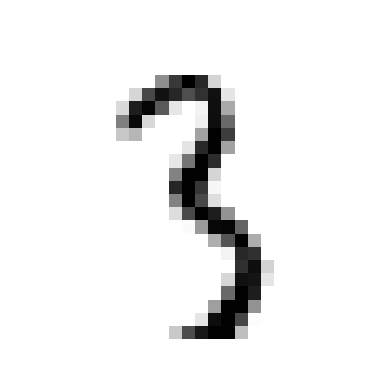

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [56]:
i = 2023
plt.imshow(x_train[:, i].reshape(28,28), cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(y_train[:, i])